In [ ]:
import json
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from datetime import datetime, timedelta
import re
import os
from dotenv import load_dotenv

## Load API key

In [ ]:
load_dotenv(override=True)
api_key = os.getenv('OPENAI_API_KEY')

if not api_key:
    print("No API key was found!")
elif not api_key.startswith("sk-proj-"):
    print("An API key was found, but it doesn't start sk-proj-;")
elif api_key.strip() != api_key:
    print("An API key was found, but it looks like it might have space or tab characters at the start or end")
else:
    print("API key found and looks good so far!")

# Initialize the LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

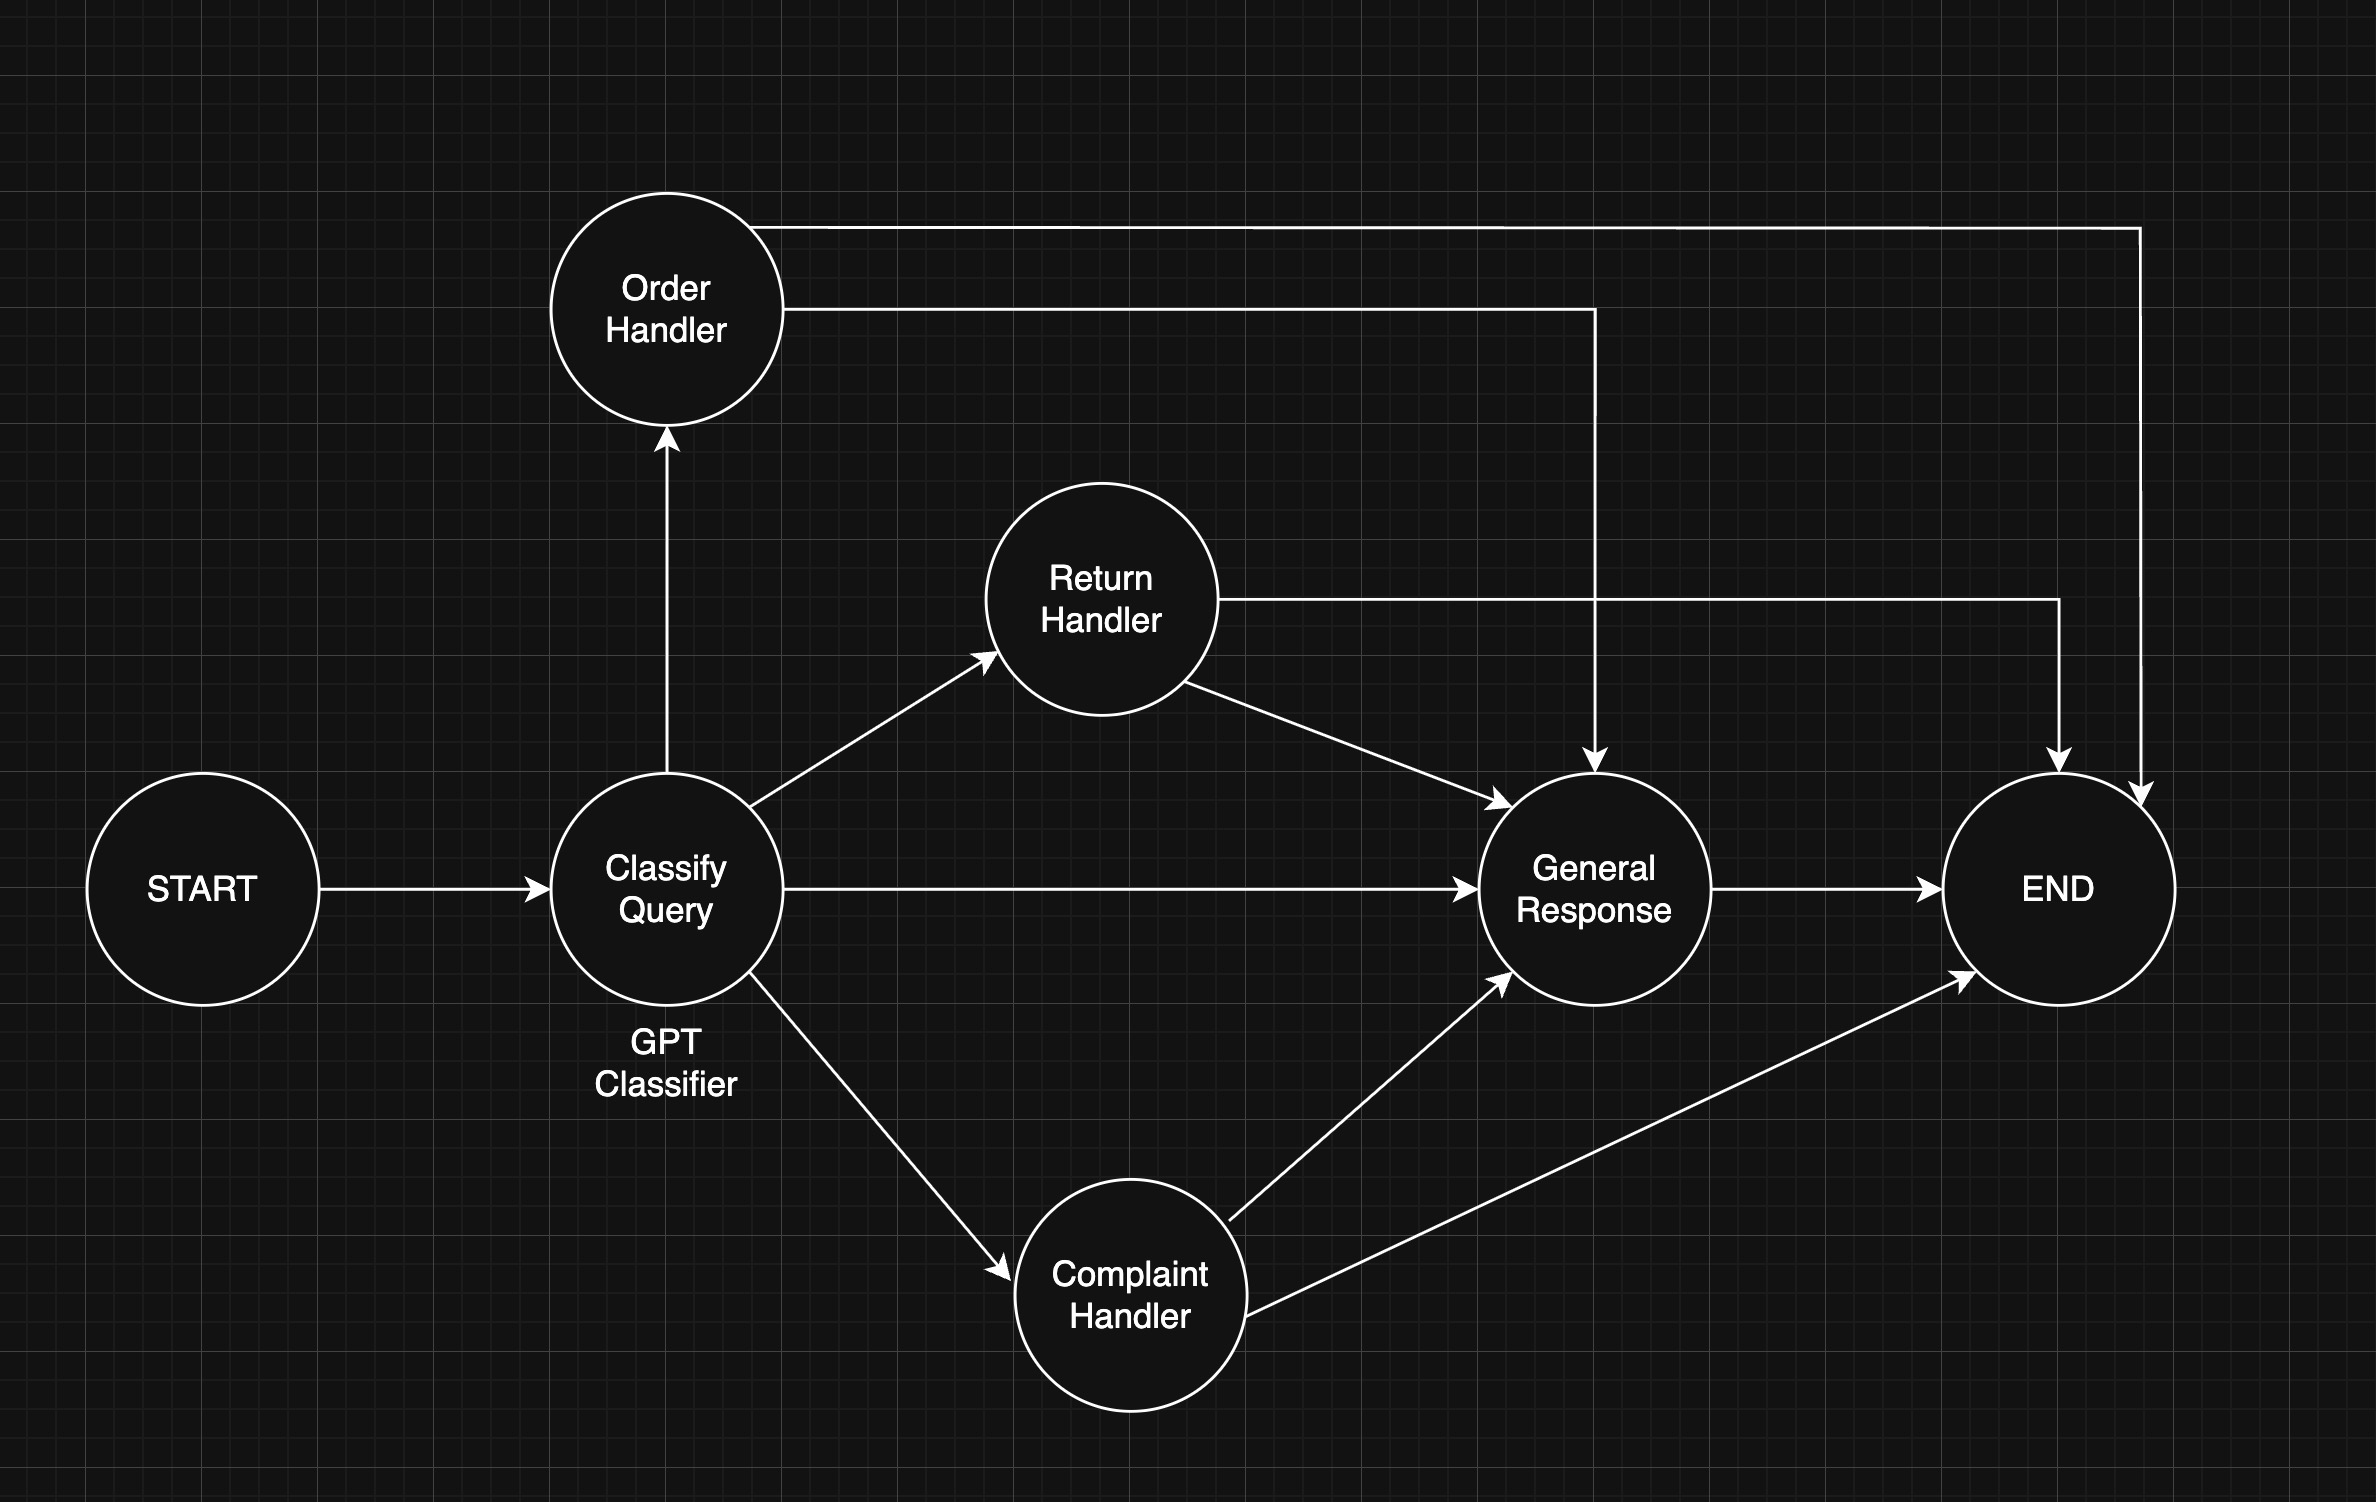

## Define the state structure

In [ ]:
class EcommerceAgentState(TypedDict):
    messages: List[Dict[str, Any]]
    customer_query: str
    query_type: str  # order_inquiry, complaint, return, refund, shipping, product_info, account
    customer_id: Optional[str]
    order_id: Optional[str]
    order_details: Optional[Dict[str, Any]]
    customer_details: Optional[Dict[str, Any]]
    resolution_steps: List[str]
    final_response: str
    current_step: str
    requires_escalation: bool
    sentiment: str
    priority: str

## Mock databases

In [ ]:
ORDERS_DB = {
    "ORD-12345": {
        "customer_id": "CUST-001",
        "order_date": "2024-01-15",
        "status": "shipped",
        "tracking_number": "TRK-789456123",
        "items": [
            {"product": "Wireless Headphones", "quantity": 1, "price": 99.99},
            {"product": "Phone Case", "quantity": 2, "price": 19.99}
        ],
        "total": 139.97,
        "shipping_address": "123 Main St, City, State 12345",
        "expected_delivery": "2024-01-20"
    },
    "ORD-67890": {
        "customer_id": "CUST-002",
        "order_date": "2024-01-18",
        "status": "processing",
        "tracking_number": None,
        "items": [
            {"product": "Laptop Stand", "quantity": 1, "price": 45.00}
        ],
        "total": 45.00,
        "shipping_address": "456 Oak Ave, Town, State 67890",
        "expected_delivery": "2024-01-25"
    }
}

CUSTOMERS_DB = {
    "CUST-001": {
        "name": "John Doe",
        "email": "john.doe@email.com",
        "phone": "+1-555-0123",
        "tier": "premium",
        "orders": ["ORD-12345"],
        "account_created": "2023-06-15"
    },
    "CUST-002": {
        "name": "Jane Smith",
        "email": "jane.smith@email.com",
        "phone": "+1-555-0456",
        "tier": "standard",
        "orders": ["ORD-67890"],
        "account_created": "2023-12-01"
    }
}

RETURN_POLICY = {
    "return_window": 30,
    "restocking_fee": 0.10,
    "free_returns": ["defective", "wrong_item", "damaged"],
    "returnable_categories": ["electronics", "clothing", "books"],
    "non_returnable": ["perishables", "custom_items", "digital_products"]
}

## Define tools

In [ ]:
@tool
def lookup_order(order_id: str) -> str:
    """Look up order details by order ID."""
    order = ORDERS_DB.get(order_id)
    if order:
        return json.dumps(order, indent=2)
    return json.dumps({"error": "Order not found"}, indent=2)

@tool
def lookup_customer(customer_id: str) -> str:
    """Look up customer details by customer ID."""
    customer = CUSTOMERS_DB.get(customer_id)
    if customer:
        return json.dumps(customer, indent=2)
    return json.dumps({"error": "Customer not found"}, indent=2)

@tool
def track_shipment(tracking_number: str) -> str:
    """Track shipment status by tracking number."""
    # Mock tracking data
    tracking_info = {
        "tracking_number": tracking_number,
        "status": "in_transit",
        "location": "Distribution Center - Chicago",
        "expected_delivery": "2024-01-20",
        "history": [
            {"date": "2024-01-15", "status": "shipped", "location": "Warehouse"},
            {"date": "2024-01-17", "status": "in_transit", "location": "Chicago Hub"},
            {"date": "2024-01-18", "status": "in_transit", "location": "Distribution Center"}
        ]
    }
    return json.dumps(tracking_info, indent=2)

@tool
def initiate_return(order_id: str, reason: str, items: List[str]) -> str:
    """Initiate a return request for specified items."""
    return_request = {
        "return_id": f"RET-{datetime.now().strftime('%Y%m%d%H%M%S')}",
        "order_id": order_id,
        "reason": reason,
        "items": items,
        "status": "initiated",
        "return_label": "https://returns.store.com/label/RET-123456",
        "instructions": "Print the return label and package items securely"
    }
    return json.dumps(return_request, indent=2)

@tool
def process_refund(order_id: str, amount: float, reason: str) -> str:
    """Process a refund for an order."""
    refund_info = {
        "refund_id": f"REF-{datetime.now().strftime('%Y%m%d%H%M%S')}",
        "order_id": order_id,
        "amount": amount,
        "reason": reason,
        "status": "processing",
        "expected_completion": "3-5 business days",
        "method": "original_payment_method"
    }
    return json.dumps(refund_info, indent=2)

@tool
def check_return_eligibility(order_id: str, item_name: str) -> str:
    """Check if an item is eligible for return."""
    order = ORDERS_DB.get(order_id)
    if not order:
        return json.dumps({"error": "Order not found"}, indent=2)
    
    order_date = datetime.strptime(order["order_date"], "%Y-%m-%d")
    days_since_order = (datetime.now() - order_date).days
    
    eligibility = {
        "item": item_name,
        "eligible": days_since_order <= RETURN_POLICY["return_window"],
        "days_remaining": max(0, RETURN_POLICY["return_window"] - days_since_order),
        "return_window": RETURN_POLICY["return_window"],
        "restocking_fee": RETURN_POLICY["restocking_fee"] if days_since_order > 14 else 0
    }
    return json.dumps(eligibility, indent=2)

@tool
def escalate_to_human(issue_type: str, priority: str, summary: str) -> str:
    """Escalate complex issues to human customer service."""
    escalation = {
        "ticket_id": f"ESC-{datetime.now().strftime('%Y%m%d%H%M%S')}",
        "issue_type": issue_type,
        "priority": priority,
        "summary": summary,
        "estimated_response": "2-4 hours" if priority == "high" else "24-48 hours",
        "status": "escalated"
    }
    return json.dumps(escalation, indent=2)

# Create tool node
tools = [lookup_order, lookup_customer, track_shipment, initiate_return, 
         process_refund, check_return_eligibility, escalate_to_human]
tool_node = ToolNode(tools)

## Define agent nodes

In [ ]:
def query_classifier(state: EcommerceAgentState) -> EcommerceAgentState:
    """Classify the customer query and extract relevant information."""
    query = state["customer_query"]
    
    # Extract order ID if present
    order_id_match = re.search(r'ORD-\d+', query.upper())
    if order_id_match:
        state["order_id"] = order_id_match.group()
    
    # Classify query type using LLM
    classification_prompt = f"""
    Classify the following customer query into one of these categories:
    - order_inquiry: Questions about order status, tracking, delivery
    - complaint: Issues with products, service, or experience
    - return: Requests to return products
    - refund: Requests for refunds or payment issues
    - shipping: Questions about shipping, delivery, or tracking
    - product_info: Questions about products, specifications, availability
    - account: Account-related questions, login issues, profile updates
    
    Also determine the sentiment (positive, neutral, negative) and priority (low, medium, high).
    
    Customer query: "{query}"
    
    Respond in JSON format with: {{"type": "category", "sentiment": "sentiment", "priority": "priority", "confidence": 0.95}}
    """
    
    messages = [
        SystemMessage(content="You are a customer service query classifier."),
        HumanMessage(content=classification_prompt)
    ]
    
    response = llm.invoke(messages)
    
    try:
        classification = json.loads(response.content)
        state["query_type"] = classification.get("type", "order_inquiry")
        state["sentiment"] = classification.get("sentiment", "neutral")
        state["priority"] = classification.get("priority", "medium")
    except:
        state["query_type"] = "order_inquiry"
        state["sentiment"] = "neutral"
        state["priority"] = "medium"
    
    state["current_step"] = "query_classified"
    return state

def order_handler(state: EcommerceAgentState) -> EcommerceAgentState:
    """Handle order-related queries."""
    if state["order_id"]:
        # Look up order details
        order_data = lookup_order.invoke({"order_id": state["order_id"]})
        order_details = json.loads(order_data)
        
        if "error" not in order_details:
            state["order_details"] = order_details
            
            # Get customer details
            customer_data = lookup_customer.invoke({"customer_id": order_details["customer_id"]})
            state["customer_details"] = json.loads(customer_data)
            
            # Track shipment if available
            if order_details.get("tracking_number"):
                tracking_data = track_shipment.invoke({"tracking_number": order_details["tracking_number"]})
                state["order_details"]["tracking_info"] = json.loads(tracking_data)
    
    state["current_step"] = "order_processed"
    return state

def return_handler(state: EcommerceAgentState) -> EcommerceAgentState:
    """Handle return requests."""
    if state["order_id"] and state["order_details"]:
        # Check return eligibility for items
        items = state["order_details"].get("items", [])
        if items:
            first_item = items[0]["product"]
            eligibility_data = check_return_eligibility.invoke({
                "order_id": state["order_id"],
                "item_name": first_item
            })
            
            eligibility = json.loads(eligibility_data)
            
            if eligibility.get("eligible", False):
                # Initiate return
                return_data = initiate_return.invoke({
                    "order_id": state["order_id"],
                    "reason": "customer_request",
                    "items": [item["product"] for item in items]
                })
                state["resolution_steps"].append(f"Return initiated: {return_data}")
            else:
                state["resolution_steps"].append("Return not eligible - outside return window")
    
    state["current_step"] = "return_processed"
    return state

def complaint_handler(state: EcommerceAgentState) -> EcommerceAgentState:
    """Handle customer complaints."""
    if state["sentiment"] == "negative" and state["priority"] == "high":
        # High priority complaints need escalation
        escalation_data = escalate_to_human.invoke({
            "issue_type": "complaint",
            "priority": "high",
            "summary": state["customer_query"]
        })
        state["resolution_steps"].append(f"Escalated to human agent: {escalation_data}")
        state["requires_escalation"] = True
    else:
        # Standard complaint handling
        if state["order_details"]:
            # Offer refund or replacement
            refund_data = process_refund.invoke({
                "order_id": state["order_id"],
                "amount": state["order_details"]["total"],
                "reason": "customer_complaint"
            })
            state["resolution_steps"].append(f"Refund processed: {refund_data}")
    
    state["current_step"] = "complaint_processed"
    return state

def response_generator(state: EcommerceAgentState) -> EcommerceAgentState:
    """Generate the final customer response."""
    context = {
        "query_type": state["query_type"],
        "customer_query": state["customer_query"],
        "order_details": state.get("order_details"),
        "customer_details": state.get("customer_details"),
        "resolution_steps": state["resolution_steps"],
        "sentiment": state["sentiment"],
        "requires_escalation": state["requires_escalation"]
    }
    
    response_prompt = f"""
    Generate a helpful, professional customer service response based on the following context:
    
    Query Type: {context['query_type']}
    Customer Query: {context['customer_query']}
    Order Details: {json.dumps(context['order_details'], indent=2) if context['order_details'] else 'None'}
    Customer Details: {json.dumps(context['customer_details'], indent=2) if context['customer_details'] else 'None'}
    Resolution Steps: {context['resolution_steps']}
    Sentiment: {context['sentiment']}
    Requires Escalation: {context['requires_escalation']}
    
    Provide a warm, helpful response that addresses the customer's concern and explains any actions taken.
    """
    
    messages = [
        SystemMessage(content="You are a helpful customer service representative."),
        HumanMessage(content=response_prompt)
    ]
    
    response = llm.invoke(messages)
    state["final_response"] = response.content
    state["current_step"] = "response_generated"
    
    return state

def should_continue(state: EcommerceAgentState) -> str:
    """Determine the next step in the workflow."""
    current_step = state["current_step"]
    query_type = state["query_type"]
    
    if current_step == "query_classified":
        if query_type in ["order_inquiry", "shipping"]:
            return "order_handler"
        elif query_type == "return":
            return "return_handler"
        elif query_type == "complaint":
            return "complaint_handler"
        else:
            return "response_generator"
    
    elif current_step in ["order_processed", "return_processed", "complaint_processed"]:
        return "response_generator"
    
    elif current_step == "response_generated":
        return "end"
    
    return "response_generator"

## Create the StateGraph

In [ ]:
workflow = StateGraph(EcommerceAgentState)

# Add nodes
workflow.add_node("classify_query", query_classifier)
workflow.add_node("order_handler", order_handler)
workflow.add_node("return_handler", return_handler)
workflow.add_node("complaint_handler", complaint_handler)
workflow.add_node("generate_response", response_generator)

# Add edges
workflow.add_edge(START, "classify_query")

workflow.add_conditional_edges(
    "classify_query",
    should_continue,
    {
        "order_handler": "order_handler",
        "return_handler": "return_handler",
        "complaint_handler": "complaint_handler",
        "response_generator": "generate_response"
    }
)

workflow.add_conditional_edges(
    "order_handler",
    should_continue,
    {
        "response_generator": "generate_response",
        "end": END
    }
)

workflow.add_conditional_edges(
    "return_handler",
    should_continue,
    {
        "response_generator": "generate_response",
        "end": END
    }
)

workflow.add_conditional_edges(
    "complaint_handler",
    should_continue,
    {
        "response_generator": "generate_response",
        "end": END
    }
)

workflow.add_conditional_edges(
    "generate_response",
    should_continue,
    {
        "end": END
    }
)

# Compile the graph
app = workflow.compile()

# Example usage
def handle_customer_query(query: str) -> Dict[str, Any]:
    """Handle a customer service query."""
    initial_state = {
        "messages": [],
        "customer_query": query,
        "query_type": "",
        "customer_id": None,
        "order_id": None,
        "order_details": None,
        "customer_details": None,
        "resolution_steps": [],
        "final_response": "",
        "current_step": "initial",
        "requires_escalation": False,
        "sentiment": "neutral",
        "priority": "medium"
    }
    
    # Execute the workflow
    final_state = app.invoke(initial_state)
    
    return final_state

In [ ]:
# Example test cases
if __name__ == "__main__":
    test_queries = [
        "Hi, I need to check the status of my order ORD-12345",
        "I want to return the wireless headphones from order ORD-12345, they don't fit well",
        "I'm very disappointed with my recent purchase. The product arrived damaged and I'm not happy with the service!",
        "Can you help me track my package? My order number is ORD-67890",
        "I need a refund for my order ORD-12345, the items were not as described"
    ]
    
    for i, query in enumerate(test_queries, 1):
        print(f"\n=== Test Case {i} ===")
        print(f"Query: {query}")
        
        result = handle_customer_query(query)
        
        print(f"Query Type: {result['query_type']}")
        print(f"Sentiment: {result['sentiment']}")
        print(f"Priority: {result['priority']}")
        print(f"Order ID: {result['order_id']}")
        print(f"Requires Escalation: {result['requires_escalation']}")
        print(f"Resolution Steps: {result['resolution_steps']}")
        print(f"Final Response: {result['final_response']}")
        print("-" * 50)

API key found and looks good so far!

=== Test Case 1 ===
Query: Hi, I need to check the status of my order ORD-12345
Query Type: order_inquiry
Sentiment: neutral
Priority: medium
Order ID: ORD-12345
Requires Escalation: False
Resolution Steps: []
Final Response: Subject: Your Order Status Update for ORD-12345

Dear John Doe,

Thank you for reaching out to us regarding the status of your order, ORD-12345. I’m happy to assist you!

Your order was shipped on January 15, 2024, and is currently in transit. Here are the details:

- **Items Ordered:**
  - Wireless Headphones (1 unit) - $99.99
  - Phone Case (2 units) - $39.98
- **Total Amount:** $139.97
- **Shipping Address:** 123 Main St, City, State 12345
- **Tracking Number:** TRK-789456123
- **Expected Delivery Date:** January 20, 2024

As of now, your package is at the Distribution Center in Chicago. Here’s a brief history of its journey:

- **January 15:** Shipped from Warehouse
- **January 17:** In transit at Chicago Hub
- **January 1